In [1]:
pwd

'C:\\Users\\vinee\\Documents\\BTP'

In [3]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt

In [4]:
import os
import glob
import re

In [5]:
os.chdir('resampled_dataset_f1_n1')

In [6]:
os.chdir('resampled_dataset')

In [7]:
my_files = glob.glob('*txt')

In [8]:
len(my_files)

131000

In [9]:
import numpy as np
#%EWT functions
def ewt_vineet(f,boundaries):
    # signal spectrum
    ff = np.fft.fft(f)
    ff = abs(ff[0:int(np.ceil(ff.size / 2))])  # one-sided magnitude

    #extend the signal by mirroring to deal with boundaries
    ltemp = int(np.ceil(f.size/2)) #to behave the same as matlab's round
    fMirr =  np.append(np.flip(f[0:ltemp-1],axis = 0),f)
    fMirr = np.append(fMirr,np.flip(f[-ltemp-1:-1],axis = 0))
    ffMirr = np.fft.fft(fMirr)
    # build the corresponding filter bank
    mfb = EWT_Meyer_FilterBank(boundaries, ffMirr.size)

    # filter the signal to extract each subband
    ewt = np.zeros(mfb.shape)
    for k in range(mfb.shape[1]):
        ewt[:, k] = np.real(np.fft.ifft(np.conjugate(mfb[:, k]) * ffMirr))
    ewt = ewt[ltemp - 1:-ltemp, :]

    return ewt


def EWT_Meyer_FilterBank(boundaries, Nsig):
    """
     =========================================================================
     function mfb=EWT_Meyer_FilterBank(boundaries,Nsig)

     This function generate the filter bank (scaling function + wavelets)
     corresponding to the provided set of frequency segments

     Input parameters:
       -boundaries: vector containing the boundaries of frequency segments (0
                    and pi must NOT be in this vector)
       -Nsig: signal length

     Output:
       -mfb: cell containing each filter (in the Fourier domain), the scaling
             function comes first and then the successive wavelets

     Author: Jerome Gilles
     Institution: UCLA - Department of Mathematics
     Year: 2012
     Version: 1.0

     Python Version: Vinícius Rezende Carvalho - vrcarva@ufmg.br
     Universidade Federal de Minas Gerais - Brasil
     Núcleo de Neurociências
     =========================================================================
     """
    Npic = len(boundaries)
    # compute gamma
    gamma = 1
    for k in range(Npic - 1):
        r = (boundaries[k + 1] - boundaries[k]) / (boundaries[k + 1] + boundaries[k])
        if r < gamma:
            gamma = r
    r = (np.pi - boundaries[Npic - 1]) / (np.pi + boundaries[Npic - 1])
    if r < gamma:
        gamma = r
    gamma = (1 - 1 / Nsig) * gamma  # this ensure that gamma is chosen as strictly less than the min

    mfb = np.zeros([Nsig, Npic + 1])

    # EWT_Meyer_Scaling
    Mi = int(np.floor(Nsig / 2))
    w = np.fft.fftshift(np.linspace(0, 2 * np.pi - 2 * np.pi / Nsig, num=Nsig))
    w[0:Mi] = -2 * np.pi + w[0:Mi]
    aw = abs(w)
    yms = np.zeros(Nsig)
    an = 1. / (2 * gamma * boundaries[0])
    pbn = (1. + gamma) * boundaries[0]
    mbn = (1. - gamma) * boundaries[0]
    for k in range(Nsig):
        if aw[k] <= mbn:
            yms[k] = 1
        elif ((aw[k] >= mbn) and (aw[k] <= pbn)):
            yms[k] = np.cos(np.pi * EWT_beta(an * (aw[k] - mbn)) / 2)
    yms = np.fft.ifftshift(yms)
    mfb[:, 0] = yms

    # generate rest of the wavelets
    for k in range(Npic - 1):
        mfb[:, k + 1] = EWT_Meyer_Wavelet(boundaries[k], boundaries[k + 1], gamma, Nsig)

    mfb[:, Npic] = EWT_Meyer_Wavelet(boundaries[Npic - 1], np.pi, gamma, Nsig)

    return mfb
def EWT_beta(x):
    """
    Beta = EWT_beta(x)
    function used in the construction of Meyer's wavelet
    """
    if x<0:
        bm=0
    elif x>1:
        bm=1
    else:
        bm=(x**4)*(35.-84.*x+70.*(x**2)-20.*(x**3))
    return bm
def EWT_Meyer_Wavelet(wn,wm,gamma,Nsig):
    """
    =========================================================
    ymw=EWT_Meyer_Wavelet(wn,wm,gamma,N)
    
    Generate the 1D Meyer wavelet in the Fourier
    domain associated to scale segment [wn,wm] 
    with transition ratio gamma
    
    Input parameters:
      -wn : lower boundary
      -wm : upper boundary
      -gamma : transition ratio
      -N : number of point in the vector
    
    Output:
      -ymw: Fourier transform of the wavelet on the band [wn,wm]
    Author: Jerome Gilles
    Institution: UCLA - Department of Mathematics
    Year: 2012
    Version: 1.0
    
    Python Version: Vinícius Rezende Carvalho - vrcarva@ufmg.br
    Universidade Federal de Minas Gerais - Brasil
    Núcleo de Neurociências 
    ==========================================================            
    """
    Mi=int(np.floor(Nsig/2))
    w=np.fft.fftshift(np.linspace(0,2*np.pi - 2*np.pi/Nsig,num = Nsig))
    w[0:Mi]=-2*np.pi+w[0:Mi]
    aw=abs(w)
    ymw=np.zeros(Nsig)
    an=1./(2*gamma*wn)
    am=1./(2*gamma*wm)
    pbn=(1.+gamma)*wn
    mbn=(1.-gamma)*wn
    pbm=(1.+gamma)*wm
    mbm=(1.-gamma)*wm

    for k in range(Nsig):
        if ((aw[k]>=pbn) and (aw[k]<=mbm)):
            ymw[k]=1
        elif ((aw[k]>=mbm) and (aw[k]<=pbm)):
            ymw[k]=np.cos(np.pi*EWT_beta(am*(aw[k]-mbm))/2)
        elif ((aw[k]>=mbn) and (aw[k]<=pbn)):
            ymw[k]=np.sin(np.pi*EWT_beta(an*(aw[k]-mbn))/2)
    ymw=np.fft.ifftshift(ymw)
    return ymw

In [13]:
boundaries = np.array([0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8])

In [15]:
len(boundaries)

9

In [29]:
ewt_output = np.zeros(shape = (126,10,len(my_files)))

In [30]:
ewt_output.shape

(126, 10, 131000)

In [31]:
for i in range(len(my_files)):
    file = np.loadtxt(my_files[i])
    ewt_output[:,:,i] = ewt_vineet(file,boundaries)

In [32]:
np.save('x_n1_my',ewt_output)

In [33]:
y = np.zeros(len(my_files))

In [51]:
loudness_data_n1 = np.array([-0.669534,-0.546282,-0.546282,-0.671033,-0.683743,-0.147340,0.084086,0.203489,0.461973,0.421456,0.525431,0.691075,0.733513,0.761766,1.076224,1.245589,1.340460,1.642738,1.773085])

In [35]:
for i in range(len(my_files)):
    test_string = my_files[i]
    temp = re.findall(r'\d+', test_string)
    res = list(map(int, temp))
    loudness_level = int(res[-1])
    index = int((loudness_level/5)-2)
    y[i] =  loudness_data_n1[index]

In [36]:
np.save('y_n1_my',y)

In [37]:
pwd

'C:\\Users\\vinee\\Documents\\BTP\\resampled_dataset_f1_n1\\resampled_dataset'

In [40]:
"""
CWT computation for 10 milliseconds data

morlet wavelet analysis
"""


'\nCWT computation for 10 milliseconds data\n\nmorlet wavelet analysis\n'

In [41]:
pwd

'C:\\Users\\vinee\\Documents\\BTP\\resampled_dataset_f1_n1\\resampled_dataset'

In [42]:
cd ..

C:\Users\vinee\Documents\BTP\resampled_dataset_f1_n1


In [43]:
cd ..

C:\Users\vinee\Documents\BTP


In [45]:
os.chdir('Dataset_3KHz_10s_n1/')

In [49]:
my_files = glob.glob('*txt')

In [50]:
len(my_files)

131000

In [52]:
loudness_data_n1 = np.array([-0.669534,-0.546282,-0.546282,-0.671033,-0.683743,-0.147340,0.084086,0.203489,0.461973,0.421456,0.525431,0.691075,0.733513,0.761766,1.076224,1.245589,1.340460,1.642738,1.773085])

In [53]:
res = np.zeros((len(my_files),10,30))

In [60]:
for i in range(len(my_files)):
    file = np.loadtxt(my_files[i])
    cwtmatr, freqs = pywt.cwt(file, np.arange(1,11), 'morl')
    res[i,:,:] = cwtmatr

In [54]:
cwtmatr, freqs = pywt.cwt(np.loadtxt(my_files[0]), np.arange(1,11), 'morl')

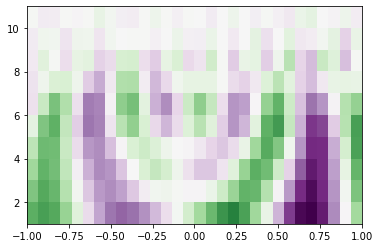

In [55]:
plt.imshow(cwtmatr, extent=[-1, 1, 1, 11], cmap='PRGn', aspect='auto',
...            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

In [59]:
len(np.loadtxt(my_files[0]))

30

In [63]:
res.shape

(131000, 10, 30)

In [65]:
np.save('C:/Users/vinee/Documents/BTP/x_n1_10ms_cwt',res)

In [66]:
y = np.zeros(len(my_files))
for i in range(len(my_files)):
    test_string = my_files[i]
    temp = re.findall(r'\d+', test_string)
    lis = list(map(int, temp))
    loudness_level = int(lis[-1])
    index = int((loudness_level/5)-2)
    y[i] =  loudness_data_n1[index]
np.save('C:/Users/vinee/Documents/BTP/y_n1_10ms_cwt',y)